# Exploritory Data Analysis:

**After I have done the basic data clean-up it was time to explore the data using different analytical plots. 
EDA is very important because it allows me to explore deeper into the dataset and find important quantities, features, and correlations. With the help of these findings not only would I be able to supply my future machine learning models with higher data quality but also, reinforce one's knowledge on the general performance of the product to which the data is related to**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#importing the data
movie_metadata = pd.read_csv("movies_md.csv")
ratings = pd.read_csv("ratings_nw.csv")

### checking if movieId values in ratings dataset are present in movies_metadata set

In [3]:
#creating a merged data set
merged_data = ratings.merge(movie_metadata, left_on="movieId", right_on='id', how="left")

#checking for amount of na values after the merge
merged_data.isna().sum()

userId              0
movieId             0
rating              0
timestamp           0
genres       14587721
id           14587721
title        14587721
dtype: int64

**There are 14,587,721 million rows of missing values genres, id, titles which means that users had rated on movies which no longer exist in the movie_metadata. As a result, my recommender cannot base/recommened movies which do not exist anymore.**

In [4]:
#dropping the rows with na values
merged_data.dropna(inplace=True)

#dropping the id column
merged_data.drop(columns=['id'], inplace=True)

In [5]:
# Basic Analysis 
TR = merged_data.userId.unique().size # Total number of users who had voted 
C = merged_data.rating.mean() # Global average rating
AM = movie_metadata.id.unique().size # Total amount of movies on the platform
WAM = merged_data.movieId.unique().size # Amount of movies voted on 
MGR1 = merged_data.groupby('userId')['rating'].count().max() # Maximum votes given by a user

print("Total number of registered users who had voted atleast once: {}".format(TR))
print("Global average rating: {:.2f}".format(C))
print("Total amount of movies on the platform: {}".format(AM))
print("Total amount of movies voted on: {}".format(WAM))
print("Maximum votes given by a user {}".format(MGR1))

Total number of registered users who had voted atleast once: 265917
Global average rating: 3.53
Total amount of movies on the platform: 45430
Total amount of movies voted on: 7565
Maximum votes given by a user 3593


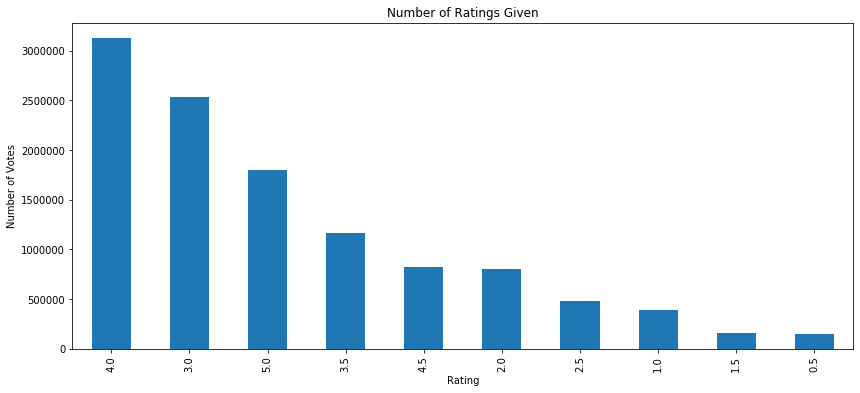

In [6]:
plt.figure(figsize=(14,6))
merged_data.rating.value_counts().plot(kind='bar')
plt.title("Number of Ratings Given")
plt.xlabel("Rating")
plt.ylabel("Number of Votes")
plt.show()

**According to the barplot we can see that most viewers have given high ratings to movies. As a result, we can conclude that most movies on the platform are of high quality**

In [7]:
# creating a new dataframe which consists of movie titles, average rating for the movie and total number of votes for the movie
ratings_avg_count = pd.DataFrame(merged_data.groupby('title')['rating'].mean())
ratings_avg_count['number_of_votes'] = pd.DataFrame(merged_data.groupby('title')['rating'].count())
ratings_avg_count.reset_index(inplace=True)
ratings_avg_count.head()

,title,rating,number_of_votes
0,!Women Art Revolution,2.802945,883
1,"$1,000 on the Black",3.000000,1
2,$5 a Day,2.246795,156
3,'Gator Bait,3.443590,195
4,'R Xmas,2.627907,86


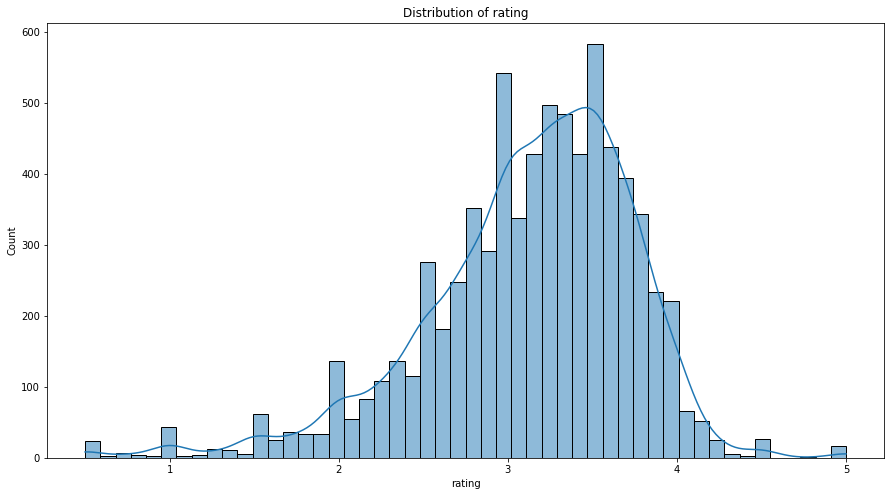

In [8]:
#checking rating distribution
plt.figure(figsize=(15,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_avg_count, x="rating",bins=50, kde=True)
plt.title("Distribution of rating")
plt.show()

**According to the graph the data has a weak normal distribution with the mean around 3.5 due to the presence of outliers in the data.**

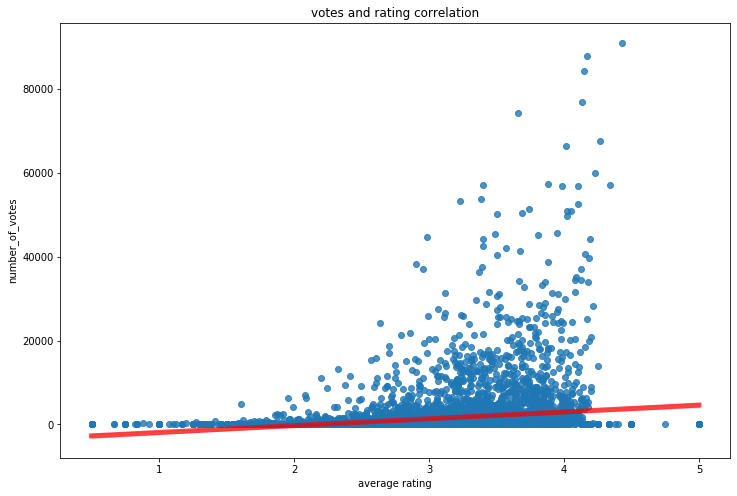

In [9]:
plt.figure(figsize=(12,8))
sns.regplot(x='rating', y='number_of_votes',data=ratings_avg_count, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title("votes and rating correlation")
plt.xlabel("average rating")
plt.show()

**There is a slight positive correlation between the average rating of a movie and the number of votes. According to the graph:<br> 1. Movies with higher average ratings actually have more number of ratings.**<br>
**2. If a movie gets more number of votes, the average rating would increase slightly**

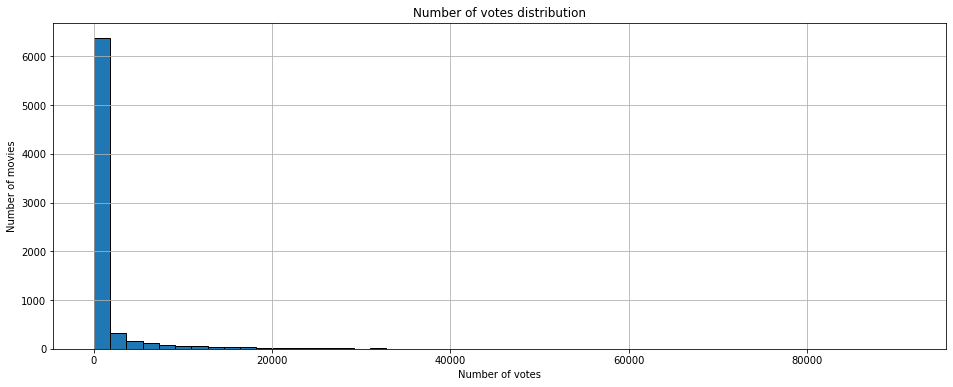

In [10]:
plt.figure(figsize=(16,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['number_of_votes'].hist(bins=50)
plt.title("Number of votes distribution")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

**Most of the movies on the platform have around 50 votes**

## Creating a Top 10 Movie List <a id='metric'></a>

**In order to create a top 10 movie list I will use IMDb's formula for computing the movie's weighted rate and use it as the movie's score.** <br>

### Why IMDb's Formula?

**IMDb's formula is built on a concept of "naive individual". Which means that it treats all users as inexperienced 


### The Formula:

**WR = (v/(v+m)) * R + (m/(v+m)) * C** 

*Where:*

**R** = Average for the movie as a number from 0.5 - 5<br>
**v** = Number of votes for the movie<br>
**m** = Minimum votes required to be listed in the top 250 (according to imdb: 25,000)<br>
**C** = The mean vote across the whole report 

### Finding  m for MovieLens platform:

**I cannot use the m value of IMDb because:**<br>
1. It is a threshold for top 250 movies. <br>
2. IMDb has 83 million users while while the platform has 270,000.<br>

**As a result, I need to scale it to be suitable for the amount of users which are on the MovieLens platform.**

**1.** Find the ratio between total number of users on IMDb (Tu1) and (m1): 83,000,000 : 25,000 --> [3320 : 1].<br> 
**2.** Find the ratio between total number of users on the platform (Tu2) and (m2) : m2 : 270,896. <br>
**3.** Compare both ratios and solve the equation for m2: 3320 * m2 = 270,896 * 1 --> **m2 = 82**. <br>

**Now that I have the minimum votes required to be listed in the top 250 in the MovieLens platform I can calculate the weighted rate for each movie, create the a list of top 250 by filtering all the movies which have less than 82 votes and lastly from that list creating another list of Top 10 movies**

### Calculation

In [11]:
#creating a variable to store the minimum number of votes needed to be in the top 250 
m = 82

#I filter the movies with less than 82 votes
filtered_movies = ratings_avg_count.loc[ratings_avg_count['number_of_votes'] >= m]

#creating a function that will compute the rating for each movie
def weighted_rate(data, m=m, C=C):
    R = data['rating']
    v = data['number_of_votes']
    wr =  (v/(v+m) * R) + (m/(m+v) * C)
    return wr

#creating a new column which will store the weighted avrage rating of the movie
filtered_movies['weighted_rate'] = filtered_movies.apply(weighted_rate, axis=1)

#sorting the values from Highest - Lowest
filtered_movies = filtered_movies.sort_values('weighted_rate', ascending=False)

#Getting the top 10 movies
top10 = filtered_movies.head(10) 

### Top 10 Movies with adjusted IMDb metric:

In [12]:
top10

,title,rating,number_of_votes,weighted_rate
6107,The Million Dollar Hotel,4.429015,91082,4.428208
4825,Sleepless in Seattle,4.339811,57070,4.338653
3930,Once Were Warriors,4.266531,67662,4.265642
2336,Hard Target,4.255074,13994,4.250866
3160,License to Wed,4.230716,60024,4.229764
3669,Murder She Said,4.213030,28280,4.211063
1321,"Cousin, Cousine",4.202589,20855,4.199966
1451,Dead Man,4.200820,7930,4.193982
244,"A Woman, a Gun and a Noodle Shop",4.199039,8948,4.192988
6541,The Thomas Crown Affair,4.189107,44324,4.187895


# Machine Learning Model Application Pipline:

## 1. Approach:

*Available Data & Features:* **movie_metadata (title, movieId), ratings (userId, movieId, rating, timestamp)**<br>
*Used Features:* **title,rating, userId, timestamp**<br>
*Libraries:* **os, scikit surprise**<br>

**I will be building a Recommender System using Collaborative Filtering. I use Collaborative Filtering because I do not have any available features about the users except their rating and timestamp (which only captures the date of when the vote was placed by a user) and about the movies except their title.**

In [14]:
import os
from surprise import BaselineOnly, Dataset, Reader, SVD, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

#loading the data using surprise
#file_path = os.path.expanduser('data.csv')
#reader = Reader(line_format='user item rating timestamp', sep='\t')
#data = Dataset.load_from_file(file_path, reader=reader)

### Sparsity Calculation:

**I will calculate the sparsity of the data with the following formula:**<br>

*S = 1 - (total_votes(data) / total_#_elements(data))*<br>

**Where:** <br>

**total_votes(data)** = total number of votes given by the users<br>
**total_#_elements** = total number of users * total number of movies<br>

**I am calculating the sparisty of the data in order to determine which type of CF approach would be the best fit: Memory-Based, Model-Based, Hybrid-Based**

In [15]:
#calculating the sparsity of the dataset
s = 1 - (merged_data.groupby('userId')['movieId'].count().sum()/(movie_metadata.id.unique().size * merged_data.userId.unique().size))
print("{:.1f}%".format(s*100))

99.9%


**I will use the Model-Based approach because it has better performance with data that has high sparsity.**

## 2. Data Preprocessing

**Before applying any machine learning model I will do the following steps:**

**1. Split the data into training and testing set.**<br>
**2. Standardize the data.**<br>

**I split the data to train and test sets before applying standardization in order to avoid data leakage. I apply standardization the data in-order to reduce the influence of outliers and help the models to converge faster.**<br>

**In order to split the data im going to use sklearn's. Im using sklearn's method because Surprise library does not have any scaling methods. As a result, I'll use sklearn's train_test_split to apply the scaling and then I'll use Surprise's Reader method to assign the scaled train and test sets to 2 variables which can be processed by the surprise library to perform training and testing.**<br>

#### Pipline:
**1. Split the data to training and testing datasets with sklearn's function (90% training, 10% testing)**<br>
**2. Apply the scaler on the training set using .fit_transform method and .transform on the test set (this way I avoid data leakage)**<br>
**3. Create 2 variables which processes the 2 sets with Surprise's reading method.**

#### The Split Ratio:

**Im splitting with a ratio of 90%:10% becuase when it comes to recommendation systems the real testing occurs in the real world  where you measure user feedback, clicks, profits, etc. For this reason, I would prefer that my model would use most of the data for training to generalize better. Hence, boosting the performance.**

In [16]:
#from the dataset using only 'userId', 'movieId', 'rating', 'timestamp' columns
train, test = train_test_split(merged_data[['userId', 'movieId', 'rating']]
                               , test_size=0.1, train_size=0.9, random_state=12)

In [17]:
#creating a scaler
rob_scaler = RobustScaler(quantile_range=(1.0, 5.0))

In [18]:
#scaling
scaled_ratings_train = rob_scaler.fit_transform(train.rating.values.reshape(-1,1))
scaled_ratings_test = rob_scaler.transform(test.rating.values.reshape(-1,1))

In [19]:
#assigning the new values to the training and test respectively
train.rating = scaled_ratings_train
test.rating = scaled_ratings_test

In [20]:
#creating reader instance
reader = Reader()

#using Surprise's Reader to process the scaled train and test sets
s_train = Dataset.load_from_df(train, reader)
s_test = Dataset.load_from_df(test, reader)

## 3. Model & Algortihm:

**I will be using Matrix Factorization with 2 predictive algorithms: Singular Vector Decomposition, Non-negative Matrix Factorization**

### Why Matrix Factorization?

**Matrix Factorization is a dimensionality reduction type machine learning model which deconstructs a given matrix A(M x N) into B(M x k) & C(k x M) matrices where k is the number of latent features. Latent features are features that try to "personalized" each user and the item he has voted for by:**<br>

*1. Predicting the rating of user(i,j) by summing up dot product of user(i) k(i,n) features with the corresponding item(j) k(j, n)* <br>
*2. Calculating the error e = Rr - Rp where: Rr - real rating, Rp - predicted rating*<br>
*3. Updating the values of k features while trying to minimize the error using a specific algorithm*

### Why SVD?

**1.SVD is a prize winning algorithm designed by Simon Funk during the Netflix Prize.**<br>

**2.It performes Matrix Decomposition by decomposing the A(u,i) to 3 matrices: B(u,k) S(k,k) C(k,i). With the help of these   metrices the algorithm is able to discover "concepts" in high sparsity data.**<br>

**3.It allows you to choose the degree of personalization by tuning the number of k latent features (a model with 1 k feature may act as a "most popular" or "top popular" recommender or as a complex personalized recommender which recommends movies to each user by their personalizations).**

In [27]:
#using the SVD() with the default parameters
algo = SVD()

#applying cross validation
cvs = cross_validation(algo, s_train, 3, False)

#applying hyper parameter tuning via GridSearchCV
algo_param_grid = {'n_epochs': [10, 15, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
algo_gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

#testing

In [ ]:
from collections import defaultdict

#a 
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

# Conclusion:

**In this project I have used 2 models: IMDb Formula & Matrix Factorization using Singular Value Decomposition.**<br>

**The first model that I have created is a static model which uses the IMDb formula as an algorithm to output the top10 movies. It's accuracy is based on all the available data. If we consider that there were no changes in the data since it was lastly deployed, the model's accuracy will be 100%. But, in reality this is not the case. Data is constantly updated and for this model to stay accurate it has to be updated everytime 
**The purpose of both models was the same but on different scale. While the IMDb Formula model outputed the Top10 movies by using only the available information in the data, the Matrix Factorization model created features of its own to help itself achieve the best performance with maximum accuracy and as a result outputed top10 recommendations for each user in the data.**

